Running PVLib's [ModelChain example](https://pvlib-python.readthedocs.io/en/stable/user_guide/modelchain.html) using Solcast API's data for the weather data. We will use one of the "unmetered locations" [available](https://docs.solcast.com.au/#unmetered-locations) from the Solcast API and the SDK: 

In [1]:
#!pip install pvlib

In [2]:
from solcast.unmetered_locations import UNMETERED_LOCATIONS

solcast_location = UNMETERED_LOCATIONS['The Colosseum']
lat, lon = solcast_location["latitude"], solcast_location["longitude"]
lat, lon

(41.89021, 12.492231)

In [3]:
import pandas as pd
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [4]:
location = Location(latitude=lat, longitude=lon)

system = PVSystem(
    surface_tilt=20, 
    surface_azimuth=200,
    module_parameters=sandia_module,
    inverter_parameters=cec_inverter,
    temperature_model_parameters=temperature_model_parameters
)


mc = ModelChain(system, location)

We will use the Solcast SDK to retrieve accurate real-world irradiance and and weather data:

In [5]:
from solcast import live

help(live.radiation_and_weather)

Help on function radiation_and_weather in module solcast.live:

radiation_and_weather(latitude: float, longitude: float, output_parameters: List[str], **kwargs) -> solcast.api.Response
    Get irradiance and weather estimated actuals for near real-time and past 7 days
    for the requested location, derived from satellite (clouds and irradiance
    over non-polar continental areas) and numerical weather models (other data).
    
    Args:
        latitude: in decimal degrees, between -90 and 90, north is positive
        longitude: in decimal degrees, between -180 and 180, east is positive
        output_parameters: list of strings with the parameters to return
    
    See https://docs.solcast.com.au/ for full list of parameters.



In [6]:
solcast_resp = live.radiation_and_weather(
    latitude=lat, 
    longitude=lon,
    output_parameters=['ghi', 'dni', 'dhi', 'air_temp', 'wind_speed_10m'],
    period='PT5M',
    hours=78
)

solcast_weather = solcast_resp.to_pandas()
# Solcast API data is "period end" while PVLib expects instantaneous
# To account for this, relabel the Solcast data to "period middle"
solcast_weather.index = solcast_weather.index - pd.Timedelta(minutes=2.5)
# timeseries in local time for readability
solcast_weather.index = solcast_weather.index.tz_convert('Australia/Sydney')

Now let's run the `ModelChain` with this weather data

In [7]:
mc.run_model(solcast_weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

Plot the DNI fetched from the Solcast API against the AC power of the site:

Text(0, 0.5, 'AC Power')

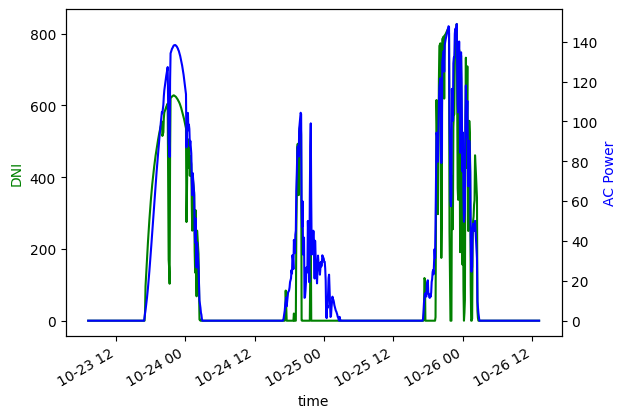

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
mc.results.weather.dni.plot(ax=ax1, color='g')
mc.results.ac.plot(ax=ax2, color='b')

ax1.set_xlabel('time')
ax1.set_ylabel('DNI', color='g')
ax2.set_ylabel('AC Power', color='b')